In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt

os.chdir('/home/bruno/datacloud')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (7.5, 5)

In [2]:
from theory.core import Pipe, Rock, TheoreticalWavelet, MultipleWavelets

In [3]:
from scipy import signal

In [4]:
from itertools import product

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from tqdm import tqdm_notebook

In [7]:
alpha_range = np.arange(1000, 6000 + 200, 200)
rho_range = np.arange(1500, 4000 + 200, 200)

window = 210
axial_delays = []
axial_modulus = []

pipe = Pipe(Rb=0.16, alpha=4875, rho=7200)
wavelets = []
for a, r in tqdm_notebook(product(alpha_range, rho_range), total=len(list(product(alpha_range, rho_range)))):
    rock = Rock(alpha=a, beta=a, rho=r)
    theoretical = TheoreticalWavelet(pipe, rock, component='axial', nyquist=5000, filterby=[30,40,90,120])
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=1.6, RC=-.357, window=None)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
        
    wavelet_full = signal.resample(w, 100000)

    delay = resampled_time[np.argmax(wavelet_full)]
    axial_delays.append(delay)
    mod = (r*(a**2)) * (1e-9)
    axial_modulus.append(mod)
    
axial_delays = np.asarray(axial_delays)
axial_delays = axial_delays + (0.0000001 - axial_delays.min())
axial_modulus = np.asarray(axial_modulus)

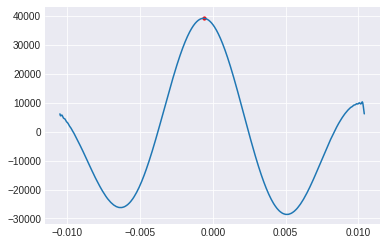

In [8]:
plt.plot(resampled_time, wavelet_full)
plt.scatter(resampled_time[np.argmax(wavelet_full)], wavelet_full[np.argmax(wavelet_full)], s=10, c='r')

In [9]:
window = 200
tangential_delays = []
tangential_modulus = []

beta_range = np.arange(300, 3500 + 200, 200)
rho_range = np.arange(1500, 4000 + 200, 200)

pipe = Pipe(Rb=0.16, alpha=4875, rho=7200)
wavelets = []
for b, r in tqdm_notebook(product(beta_range, rho_range), total=len(list(product(beta_range, rho_range)))):
    rock = Rock(beta=b, rho=r, component='tangential')
    theoretical = TheoreticalWavelet(pipe, rock, component='tangential', nyquist=5000, filterby=[30,45,160,200])
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time_full = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=3.2, RC=.13, window=None)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
    
    wavelet_full = signal.resample(w, 100000)
    
#     # taking the zero crossing
#     resampled_time = resampled_time_full[int(wavelet_full.shape[0]/2):np.argmin(wavelet_full)]
#     wavelet = wavelet_full[int(wavelet_full.shape[0]/2):np.argmin(wavelet_full)]
    
#     idx = (np.abs(wavelet - 0)).argmin()
    
#     delay = resampled_time[idx]

    delay = resampled_time[np.argmax(wavelet_full)]
    
    tangential_delays.append(delay)
    mod = (r*(b**2)) * (1e-9)
    tangential_modulus.append(mod)
    
tangential_delays = np.asarray(tangential_delays)
tangential_delays = tangential_delays + (0.0000001 - tangential_delays.min())
tangential_modulus = np.asarray(tangential_modulus)

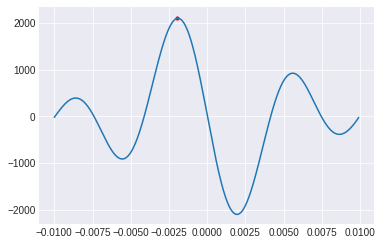

In [16]:
plt.plot(resampled_time_full, wavelet_full)
plt.scatter(resampled_time[np.argmax(wavelet_full)], wavelet_full[np.argmax(wavelet_full)], s=10, c='r')

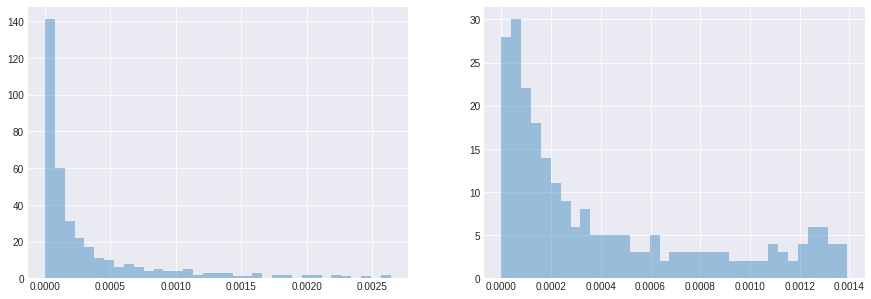

In [57]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(axial_delays, label='axial_time', ax=ax1, kde=False, bins=35)
sns.distplot(tangential_delays, label='tangential_time', ax=ax2, kde=False, bins=35)

In [58]:
from scipy.optimize import curve_fit

def power_func(x, a, b):
    return a * (np.asarray(x)**b)

def power_func2(x, a, b, c, aa, bb):
    return ((a * (np.asarray(x)**b) + c) / (aa * np.asarray(x) + bb))

def power_func3(x, a, b, c, aa, bb, cc, d):
    return ((a * (np.asarray(x)**b) + c)/ (aa  * (np.asarray(x) ** 2) + bb * x + cc) * d)

def power_func4(x, a, b, c, aa, bb, d):
    return ((a * (np.asarray(x)**b) + c)  / (aa * np.asarray(x) + bb) * d)

def exponential_func(x, a, b, c):
    return a * np.exp(-b * np.asarray(x)) + c

def second_order_exponential_func(x, a, b, aa, bb, c):
    return a * np.exp(b * np.asarray(x)) + aa * (np.exp(bb * np.asarray(x)))**2 + c

In [59]:
current_axial_func = power_func3

In [60]:
current_tangential_func = power_func4

In [61]:
axial_const = curve_fit(current_axial_func, 
                        axial_delays[(axial_modulus) > 0],
                        axial_modulus[(axial_modulus) > 0], maxfev=1000000)[0].round(4)

In [62]:
tangential_const = curve_fit(current_tangential_func, 
                             tangential_delays[(tangential_delays) >= 0],
                             tangential_modulus[(tangential_delays) >= 0], 
                             maxfev=100000)[0]

In [63]:
axial_const

array([ 3.34000000e-02, -2.19400000e-01,  2.64786000e+01, -1.25231301e+06,
        6.38963520e+03,  2.09000000e-01,  1.12980000e+00])

In [ ]:
((a * (np.asarray(x)**b) + c)/ (aa  * (np.asarray(x) ** 2) + bb * x + cc) * d)

In [68]:
axial_const

array([ 3.34000000e-02, -2.19400000e-01,  2.64786000e+01, -1.25231301e+06,
        6.38963520e+03,  2.09000000e-01,  1.12980000e+00])

In [69]:
'''({} * x^({}) + {}) / ({} * (x^2) + {} * x + {}) * {}'''.format(*axial_const.round(5))

'(0.0334 * x^(-0.2194) + 26.4786) / (-1252313.006 * (x^2) + 6389.6352 * x + 0.209) * 1.1298'

In [72]:
'''({} * x^({}) + {}) / ({} * x + {}) * {}'''.format(*tangential_const.round(5))

'(-459.91095 * x^(1.62862) + 0.01161) / (23.31509 * x + 0.00128) * 5.5802'

In [73]:
import matplotlib.ticker as ticker


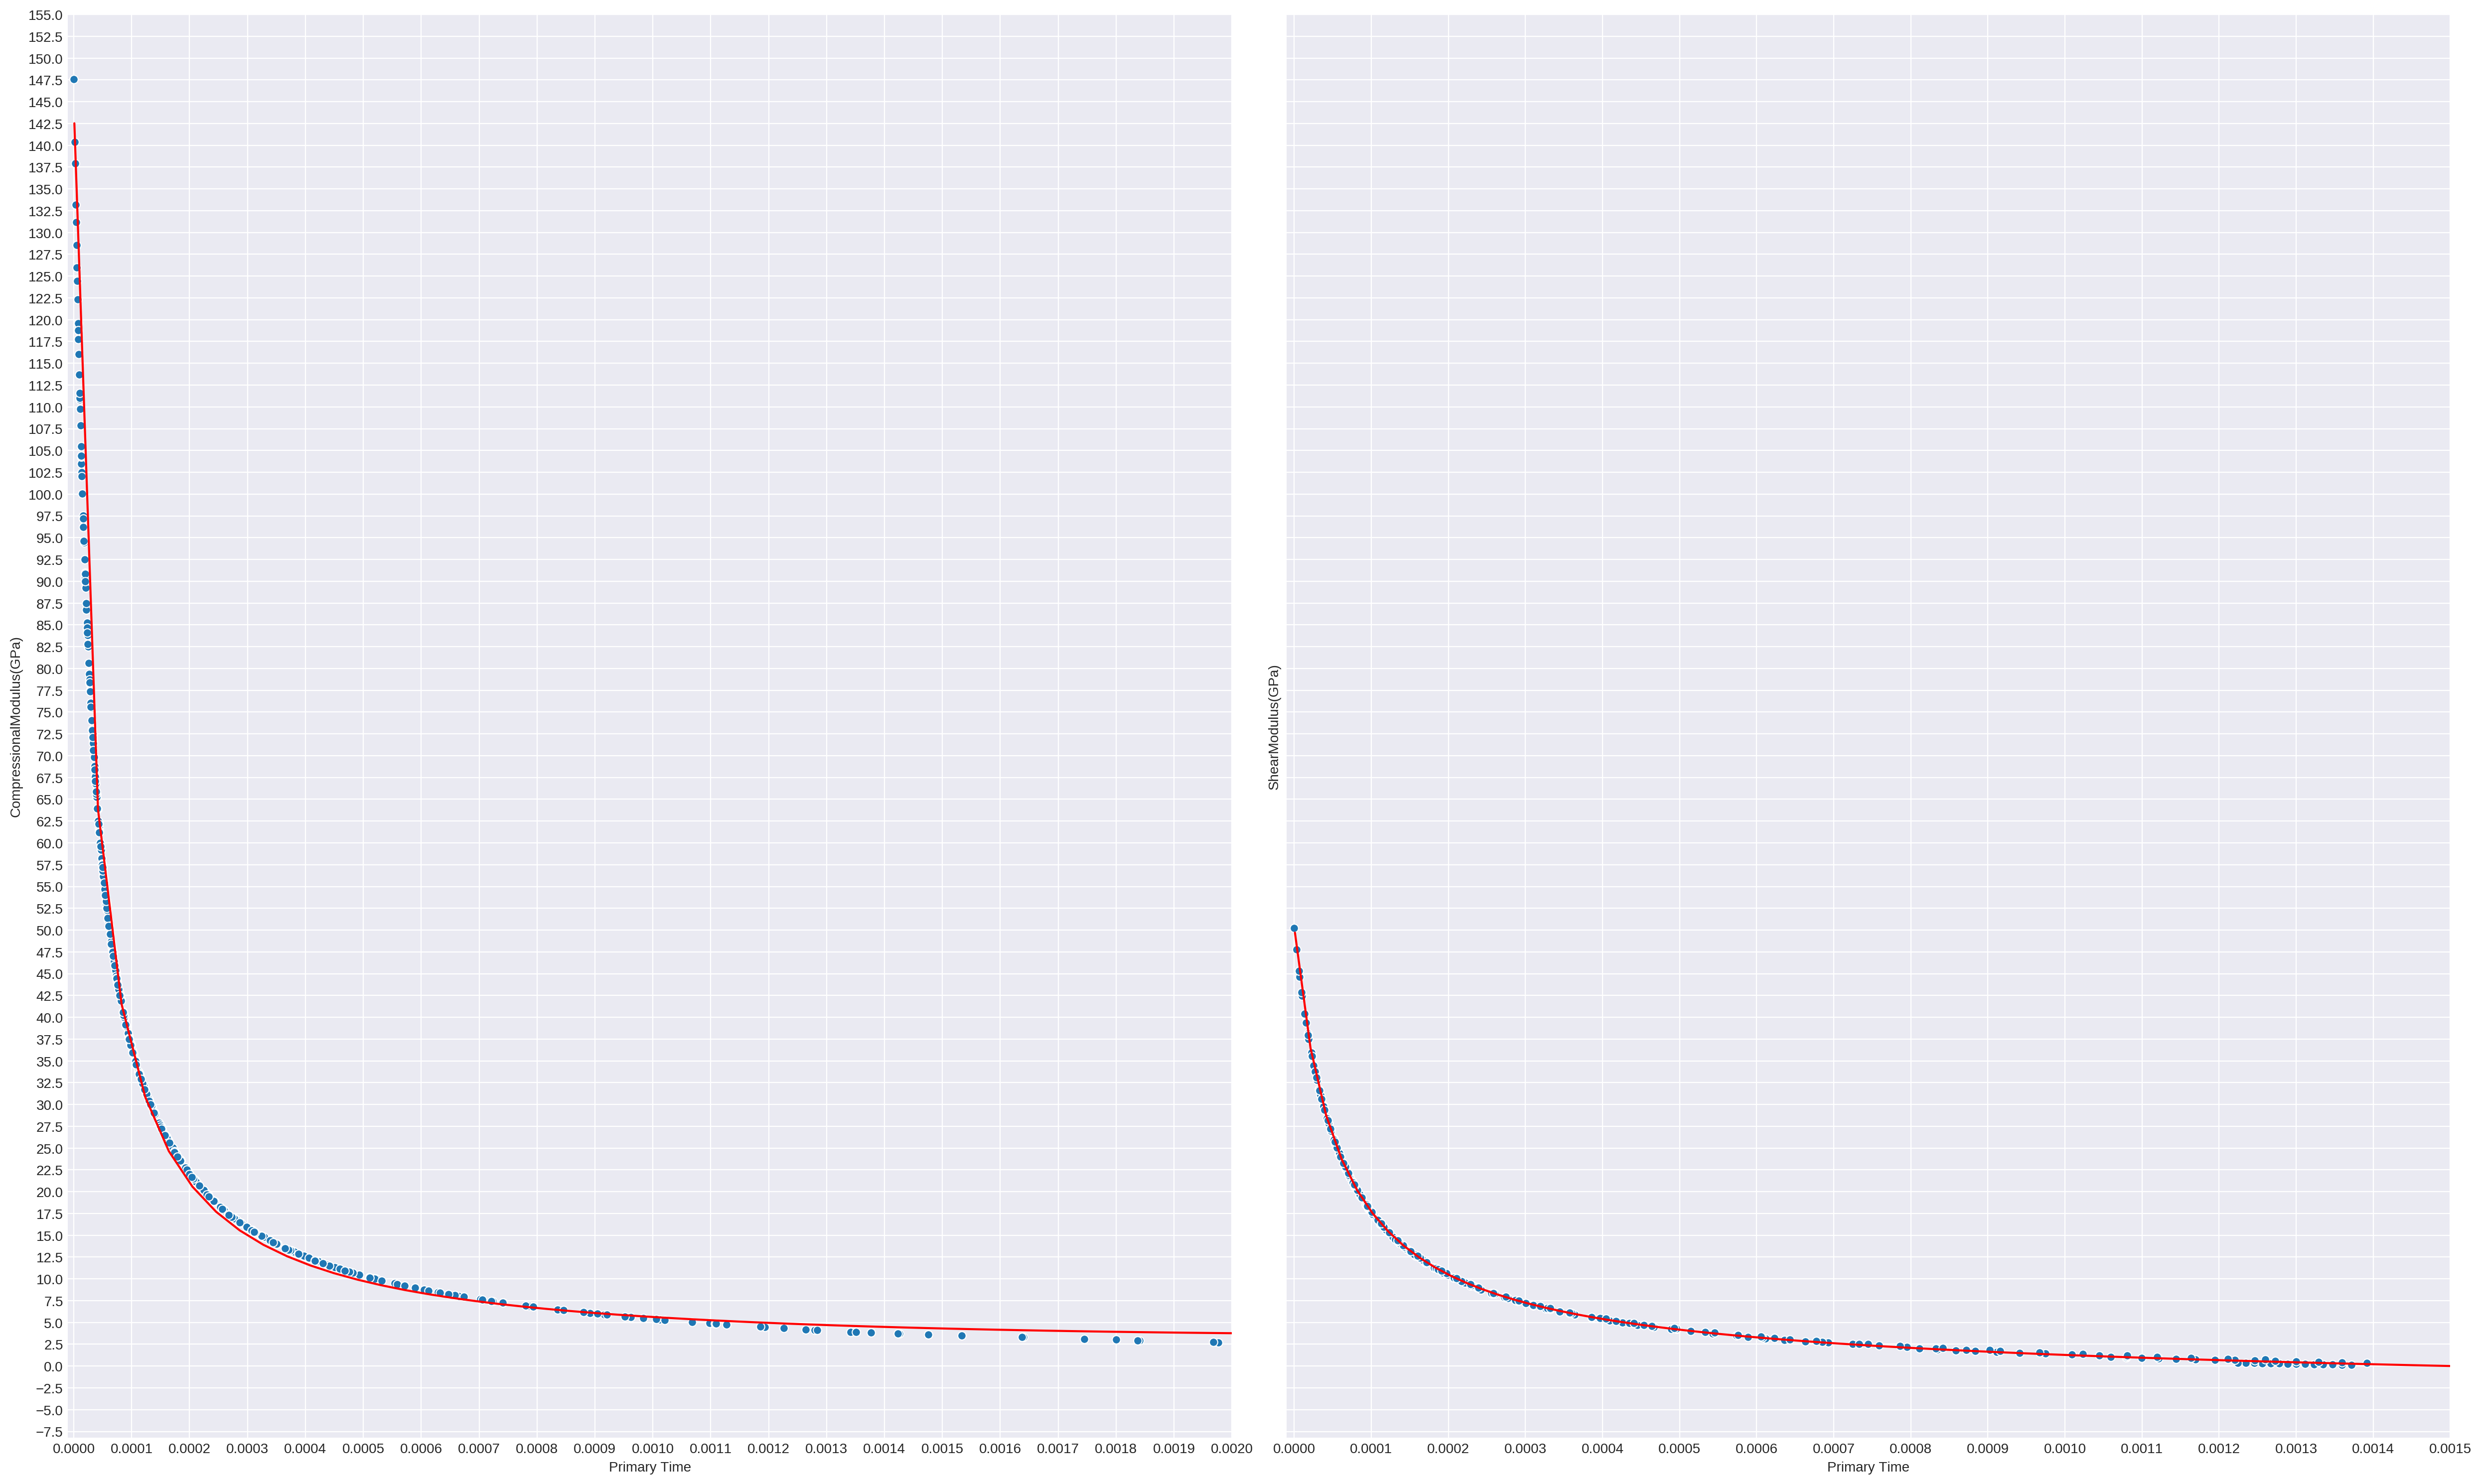

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])

axes[0].plot(np.linspace(0.000001, 0.002), current_axial_func(np.linspace(0.000001, 0.002), *axial_const.round(5)), '-', color='r')
axes[1].plot(np.linspace(0.000001, 0.002, 100), current_tangential_func(np.linspace(0.000001, 0.002, 100), *tangential_const.round(5)), '-', color='r')


axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')

axes[0].set_xlim(-0.00001, 0.002)
axes[1].set_xlim(-0.00001, 0.0015)

for ax in axes.ravel():
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.0001))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

fig.tight_layout()